# K-means 군집분석

> 1. 모든 사람을 여러 군집으로 분류하기  
> 2. 분류된 곳에서 RFM이 높은 사람 선별하기  
> 3. 각 분류 별로 RFM이 낮은 사람에게 RFM 이 높은 사람의 전략을 추천하기  

## Pre Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, confusion_matrix

# 결측치처리 + 인코딩 / 스케일링 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score
# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer

In [3]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from yellowbrick.cluster import SilhouetteVisualizer
import joblib

In [11]:
df_mem = pd.read_csv('./data/Member_data6.csv', encoding='euc-kr')
df_mem2= df_mem.copy()

In [12]:
df_sale = pd.read_csv('./data/new_sales4.csv', encoding='euc-kr')

In [13]:
def pants(x):
    if x in ['1단계', '2단계', '3단계', '4단계', '5단계', '6단계', '7단계']:
        return ('기저귀')
    else:
        return(x)

In [14]:
def change_momcu(x):
    if x['상품명'] == '맘큐 허그박스':
        return ('맘큐')
    else:
        return (x['물품대분류'])

In [15]:
# 기저귀
df_sale['물품대분류'] = df_sale['물품대분류'].apply(lambda x:pants(x))

In [16]:
df_sale['물품대분류'] = df_sale.apply(lambda x:change_momcu(x), axis=1)

In [17]:
df_mem2 = pd.merge(df_mem, df_sale.groupby('고객번호')['물품대분류'].apply(list).reset_index(), on='고객번호')
df_mem2 = df_mem2.rename(columns = {'물품대분류':'물품구매현황'})

In [10]:
df_mem2.columns

Index(['고객번호', '성별', '결혼유무', '거주지역', '연령', '결제등록카드', '유입경로', '자녀여부',
       'recendancy', 'frequency', 'monetary', 'rfm', '총구매금액', '첫주문일', '가입일',
       '첫주문까지일', '첫구매물품', '첫결제금액', '첫구매월령', 'chun', 'churn_predict1',
       'churn_predict0', '물품구매현황'],
      dtype='object')

- 설명변수(x) 선정

고객 개인정보 : ['성별', '결혼유무', '거주지역', '연령', '결제등록카드', '유입경로', '자녀여부']  
고객 구매정보 : ['recendancy', 'frequency', 'monetary', '총구매금액', '첫주문일', '첫주문까지일', '첫구매월령']

In [18]:
df_mem2['첫구매물품'] = df_mem2['첫구매물품'].apply(lambda x:pants(x))

In [12]:
x_value = df_mem2[['성별', '결혼유무', '거주지역', '유입경로', '자녀여부']]
x_numeric = df_mem2[['첫결제금액', '연령', 'churn_predict0']]

In [13]:
scaler = MinMaxScaler()
x_numeric_scale = scaler.fit_transform(x_numeric)
x_numeric_scale = pd.DataFrame(x_numeric_scale, columns = x_numeric.columns)

In [14]:
x_value_scale = pd.get_dummies(x_value)

In [15]:
df_x = pd.concat([x_value_scale, x_numeric_scale], axis=1)

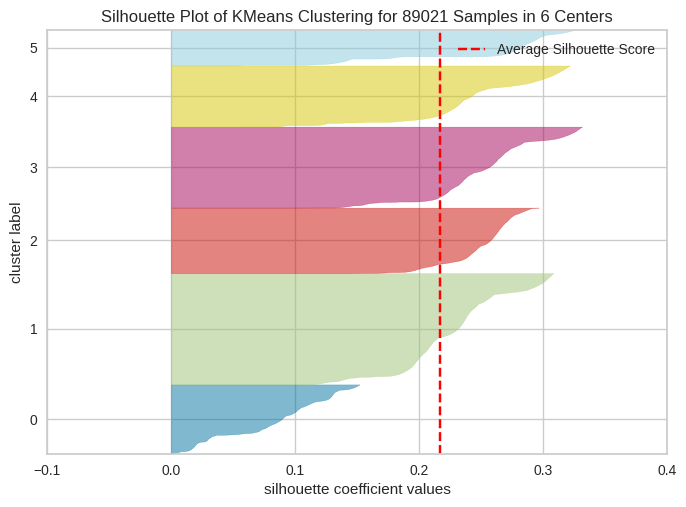

실루엣 계수 :  0.2169


In [16]:
clus=KMeans(6)
graph_sil = SilhouetteVisualizer(clus, colors='yellowbrick')
graph_sil.fit(df_x)
graph_sil.show()
print ('실루엣 계수 : ', round(graph_sil.silhouette_score_, 4))


In [ ]:
plt.figure(figsize=(15,5))
graph_sil.show()

In [123]:
for i in range(4, 9):
    clus = KMeans(n_clusters=i, init='k-means++', max_iter=300,random_state=0).fit(df_x)
    clus_list = clus.labels_
    df_mem2['kmeans'] = clus_list
    
    average_score = silhouette_score(df_x, df_mem2['kmeans'])
    print('붓꽃 데이터셋 Silhouette Analysis Score:', average_score)

붓꽃 데이터셋 Silhouette Analysis Score: 0.22429294388121884
붓꽃 데이터셋 Silhouette Analysis Score: 0.245405220471277
붓꽃 데이터셋 Silhouette Analysis Score: 0.26286666893602456
붓꽃 데이터셋 Silhouette Analysis Score: 0.18541833296393936
붓꽃 데이터셋 Silhouette Analysis Score: 0.22326689379220338


In [125]:
clus = KMeans(n_clusters=6, init='k-means++', max_iter=1000,random_state=0).fit(df_x)
clus_list = clus.labels_
df_mem2['kmeans'] = clus_list

average_score = silhouette_score(df_x, df_mem2['kmeans'])
print('붓꽃 데이터셋 Silhouette Analysis Score:', average_score)

붓꽃 데이터셋 Silhouette Analysis Score: 0.26286666893602456


In [17]:
cluster_kmeans = [i+1 for i in clus.labels_]
df_mem2['kmeans'] = cluster_kmeans
df_mem2.head()

,고객번호,성별,결혼유무,거주지역,연령,결제등록카드,유입경로,자녀여부,recendancy,frequency,...,가입일,첫주문까지일,첫구매물품,첫결제금액,첫구매월령,chun,churn_predict1,churn_predict0,물품구매현황,kmeans
0,201812310749735,여,기혼,인천,37.0,국민은행,인스타그램,Yes,0.4,0.2,...,20181231,125,수유용품,16314,baby2,2,0.429604,0.570396,"[수유용품, 기저귀]",2
1,201812310749770,여,기혼,제주,33.0,국민은행,검색광고,Yes,0.0,0.2,...,20181231,59,티슈,3800,NaN,0,0.165857,0.834143,[티슈],1
2,201812310749771,여,기혼,부산,32.0,하나은행,네이버블로그,Yes,0.0,0.2,...,20181231,133,기저귀,47922,baby22,0,0.043019,0.956981,[기저귀],4
3,201812310749774,여,미혼,경남,34.0,기업은행,지인추천,No,1.0,0.2,...,20181231,129,기저귀,39788,baby2,1,0.406583,0.593417,"[기저귀, 기저귀]",3
4,201812310749780,여,기혼,서울,32.0,신한은행,직접검색,Yes,0.0,0.2,...,20181231,30,이벤트,19900,baby1,0,0.189245,0.810755,[이벤트],1


In [18]:
df_mem2['kmeans'].value_counts().sort_index()

1    14571
2    23400
3    13769
4    17030
5    12848
6     7403
Name: kmeans, dtype: int64

In [128]:
joblib.dump(clus, './data/kmeans_model.pkl')

['./data/kmeans_model.pkl']

In [54]:
tmp = pd.get_dummies(df_sale['물품대분류'].unique())

# 각 군집별 장바구니 분석

군집별 상위 구매자를 뽑아서 장바구니 분석

### 군집별 인원 확인

In [19]:
df_mem2.groupby(['kmeans'])['rfm'].value_counts().unstack().T

kmeans,1,2,3,4,5,6
rfm,,,,,,
1,3056,4972,2862,3579,2612,1517
2,5014,8120,4870,5877,4450,2576
3,2628,4111,2326,2921,2237,1299
4,2821,4460,2645,3314,2542,1451
5,1052,1737,1066,1339,1007,560


In [287]:
df_mem2.groupby(['kmeans'])['rfm'].value_counts().unstack().T.to_csv('./data/kmeans/kmeans_rfm_count.csv', encoding='euc-kr')

## 연관분석

In [161]:
apri_list = []
for i in range(1, 7):
    tmp = df_mem2[df_mem2['kmeans'] == i]['물품구매현황']
    te = TransactionEncoder()
    te_ary = te.fit(tmp).transform(tmp)
    df3 = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = apriori(df3, min_support=0.03, use_colnames=True)
    apri_list.append(frequent_itemsets)

In [162]:
df_mem2['kmeans'].value_counts()

6    28897
2    21055
3    13769
1    10167
5     7730
4     7403
Name: kmeans, dtype: int64

In [175]:
association_rules(apri_list[5], metric="lift", min_threshold=1.2).sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(수유용품),(아이_생활용품),0.224383,0.074471,0.033256,0.148211,1.990173,0.016546,1.086570
5,(아이_생활용품),(수유용품),0.074471,0.224383,0.033256,0.446561,1.990173,0.016546,1.401450
6,(티슈),(주방용품),0.179430,0.100806,0.031007,0.172806,1.714240,0.012919,1.087041
7,(주방용품),(티슈),0.100806,0.179430,0.031007,0.307587,1.714240,0.012919,1.185086
3,(티슈),(생리대),0.179430,0.109008,0.033152,0.184764,1.694958,0.013593,1.092925
2,(생리대),(티슈),0.109008,0.179430,0.033152,0.304127,1.694958,0.013593,1.179194
0,(기저귀),(아이_생활용품),0.351351,0.074471,0.033464,0.095243,1.278918,0.007298,1.022958
1,(아이_생활용품),(기저귀),0.074471,0.351351,0.033464,0.449349,1.278918,0.007298,1.177968


In [274]:
for i in range(len(apri_list)):
    tmp = association_rules(apri_list[i], metric="lift", min_threshold=1.2).sort_values('lift', ascending=False)
    tmp.to_csv(f'./data/kmeans/association_rules_{i+1}', encoding='euc-kr')

## 군집별 기저귀 구매 주기

In [19]:
df_mem2['kmeans'].value_counts()

6    27744
2    20175
3    13182
1     9731
5     7375
4     7080
Name: kmeans, dtype: int64

In [20]:
# Kmeans 등급별 많이 구매한 사람
df_mem2[df_mem2['rfm'] >= 4]['kmeans'].value_counts()

6    7323
2    5510
3    3520
1    2584
5    1963
4    1901
Name: kmeans, dtype: int64

In [23]:
def check_interval(x, tmp1):
    if '기저귀' in x['물품구매현황']:
        tmp = tmp1[tmp1['고객번호'] == x['고객번호']]
        interval = np.datetime64(tmp['구매일'].max(), 'D') - np.datetime64(tmp['구매일'].min(), 'D')
        return (interval)
    else:
        return (-1)

In [25]:
tmp1 = df_mem2[df_mem2['kmeans'] == 1].apply(lambda x:check_interval(x, df_sale[df_sale['물품대분류'] == '기저귀']), axis=1)
tmp1 = tmp1[tmp1 != -1]

In [257]:
tmp1.sum() / len(tmp1)

numpy.timedelta64(105,'D')

In [260]:
interval_list = []
for i in range(1, 7):
    group_member = df_mem3[df_mem3['kmeans'] == i]
    tmp = group_member.apply(lambda x:check_interval(x, df_sale[df_sale['물품대분류'] == '기저귀']), axis=1)
    tmp = tmp[tmp != -1]
    interval_list.append(tmp.sum()/len(tmp))

In [262]:
interval_list

[numpy.timedelta64(105,'D'),
 numpy.timedelta64(114,'D'),
 numpy.timedelta64(105,'D'),
 numpy.timedelta64(102,'D'),
 numpy.timedelta64(103,'D'),
 numpy.timedelta64(109,'D')]

## 군집별 첫 구매 물품 확률



In [300]:
df_mem['kmeans'] = df_mem3['kmeans']

In [310]:
df_mem[df_mem['kmeans'] == 5]['첫구매물품'].value_counts().head()

2단계     398
수유용품    358
3단계     286
이벤트     243
4단계     123
Name: 첫구매물품, dtype: int64

당연하게도.. 첫구매 확률은 모두 같다..

## 군집별 각 물품 구매확률

## 첫구매, 둘구매 연관규칙

In [ ]:
df_mem = pd.read_csv('./data/Member_data4.csv', encoding='euc-kr')

In [279]:
def tt(x):
    try:
        return (x[1])
    except:
        return (None)

In [280]:
te1 = df_sale.groupby('고객번호')['물품대분류'].apply(list).apply(lambda x:tt(x)).reset_index()
te1 =te1.rename(columns={'물품대분류':'두번째구매'})
te2 = pd.merge(df_mem, te1, on='고객번호')

In [281]:
tt.to_csv('./data/두번째구매_member.csv', encoding='euc-kr', index=False)
te3 = te2[['첫구매물품', '두번째구매']].dropna()
te4 = te3.apply(lambda x:[x['첫구매물품'], x['두번째구매']], axis=1)

In [303]:
te = TransactionEncoder()
te_ary = te.fit(te4).transform(te4)
te5 = pd.DataFrame(te_ary, columns=te.columns_)

In [319]:
frequent_itemsets = apriori(te5, min_support=0.001, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.038917,(1단계)
1,0.126977,(2단계)
2,0.154060,(3단계)
3,0.077969,(4단계)
4,0.036496,(5단계)
...,...,...
108,0.015929,"(주방용품, 티슈)"
109,0.002444,"(주방용품, 화장품)"
110,0.007512,"(티슈, 청결용품)"
111,0.007376,"(화장품, 청결용품)"


In [318]:
association_rules(frequent_itemsets, metric="lift", min_threshold=-5).sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
84,(5단계),(6단계),0.036496,0.009888,0.001199,0.032858,3.323172,0.000838,1.023751
85,(6단계),(5단계),0.009888,0.036496,0.001199,0.121281,3.323172,0.000838,1.096488
185,(청결용품),(화장품),0.054732,0.046587,0.007376,0.134766,2.892798,0.004826,1.101914
184,(화장품),(청결용품),0.046587,0.054732,0.007376,0.158329,2.892798,0.004826,1.123085
66,(5단계),(4단계),0.036496,0.077969,0.005453,0.149411,1.916285,0.002607,1.083991
...,...,...,...,...,...,...,...,...,...
88,(5단계),(수유용품),0.036496,0.242098,0.001652,0.045257,0.186938,-0.007184,0.793829
47,(마스크),(3단계),0.041360,0.154060,0.001041,0.025164,0.163339,-0.005331,0.867777
46,(3단계),(마스크),0.154060,0.041360,0.001041,0.006756,0.163339,-0.005331,0.965160
60,(3단계),(청결용품),0.154060,0.054732,0.001335,0.008665,0.158316,-0.007097,0.953530


In [322]:
#첫구매물품
tee1 = df_sale.groupby('고객번호')['물품대분류'].apply(list).apply(lambda x:x[0]).reset_index()

In [329]:
# 2번째 구매가 없는사람들
df_tmp = pd.merge(tee1, te1, on='고객번호')[pd.merge(tee1, te1, on='고객번호').isna().sum(axis=1) == 1]

In [340]:
# 물품 별 나갈 확률 (2구매 없을 확률)
df_tmp['물품대분류'].value_counts()/tee1['물품대분류'].value_counts()

1단계        0.439503
2단계        0.408025
3단계        0.443573
4단계        0.528789
5단계        0.569959
6단계        0.586621
7단계        0.454545
기타         0.611111
마스크        0.591218
맘큐         0.782281
생리대        0.489714
수유용품       0.487050
아이_생활용품    0.491737
어른_생활용품    0.459176
음식         0.700820
이벤트        0.545049
장난감        0.514493
주방용품       0.562193
청결용품       0.546961
티슈         0.593557
화장품        0.576136
Name: 물품대분류, dtype: float64

# 첫구매 물품 별 90일 이내 재구매 확률1

In [417]:
df_sale = pd.read_csv('./data/new_sales4.csv',encoding='euc-kr')

In [347]:
tee1.head()

,고객번호,물품대분류
0,201812310749735,수유용품
1,201812310749770,티슈
2,201812310749771,3단계
3,201812310749774,3단계
4,201812310749780,이벤트


In [349]:
df_tmp = df_sale.groupby('고객번호')['주문번호'].apply(list).apply(lambda x:x[:2]).reset_index()

In [364]:
df_tmp2 = df_tmp[df_tmp['주문번호'].apply(len) > 1]

In [365]:
df_tmp2

,고객번호,주문번호
0,201812310749735,"[201905052342970, 202002203424450]"
3,201812310749774,"[201905092356247, 201907282649358]"
5,201812310749783,"[201901161908099, 201906302542644]"
6,201812310749784,"[201904292316940, 201906242522007]"
7,201812310749787,"[201812311861810, 201901201920825]"
...,...,...
81045,201912281057984,"[202002223431991, 202002223431991]"
81047,201912281057991,"[202001153300382, 202004053627524]"
81048,201912281057997,"[20200706205941-05897002163, 20200706205941-05..."
81051,201912281058006,"[201912283245106, 20200521172454-86563196093]"


In [366]:
tmp1 = df_tmp2['주문번호'].apply(lambda x:x[0][:8])
tmp2 = df_tmp2['주문번호'].apply(lambda x:x[1][:8])

In [375]:
(tmp2.astype('datetime64') - tmp1.astype('datetime64')).dt.days

0        291
3         80
5        165
6         56
7         20
        ... 
81045      0
81047     81
81048      0
81051    145
81054    184
Name: 주문번호, Length: 36231, dtype: int64

In [385]:
# 첫구매 후 90일 이내 재 구매한 사람과 첫구매 물품
tee1.loc[(tmp2.astype('datetime64') - tmp1.astype('datetime64')).dt.days]

,고객번호,물품대분류
291,201901010750549,생리대
80,201812310750006,수유용품
165,201901010750228,수유용품
56,201812310749934,수유용품
20,201812310749833,5단계
...,...,...
0,201812310749735,수유용품
81,201812310750007,4단계
0,201812310749735,수유용품
145,201901010750177,1단계


In [396]:
# 두번째 구매까지 걸린 시간
tmp3 = (tmp2.astype('datetime64') - tmp1.astype('datetime64')).dt.days

In [401]:
tmp4 = tee1.loc[tmp3.index]

In [402]:
tmp4['두번째구매까지기간'] = tmp3

In [409]:
tmp4.to_csv('./data/두번째까지기간.csv', encoding='euc-kr', index=False)

In [407]:
tmp4[tmp4['두번째구매까지기간'] <= 90]['물품대분류'].value_counts() / tee1['물품대분류'].value_counts()

1단계        0.420851
2단계        0.453810
3단계        0.426262
4단계        0.350451
5단계        0.328189
6단계        0.313894
7단계        0.363636
기타         0.333333
마스크        0.300052
맘큐         0.119512
생리대        0.377158
수유용품       0.404666
아이_생활용품    0.401965
어른_생활용품    0.409738
음식         0.184426
이벤트        0.350949
장난감        0.394928
주방용품       0.313938
청결용품       0.361666
티슈         0.280215
화장품        0.340489
Name: 물품대분류, dtype: float64

In [391]:
tee1['물품대분류'].value_counts()

맘큐         11547
이벤트        11221
수유용품       10888
티슈          8754
2단계         6181
3단계         6123
생리대         4229
주방용품        3867
4단계         3213
청결용품        2353
아이_생활용품     2239
1단계         2091
화장품         2003
5단계         1944
마스크         1913
어른_생활용품     1335
6단계          583
장난감          276
음식           244
7단계           33
기타            18
Name: 물품대분류, dtype: int64

In [ ]:
pd.read_